This is an online notebook set up with CasADi

After clicking the code block below,
press __Shift-Enter__ to execute it

This example compares GGN and SCP to solve an optimization problem:

\begin{equation}
  \begin{array}{cl}
    \underset{w}{\textrm{minimize}} & \phi(w) \\
    \textrm{subject to} &  G(w)=0 \\
  \end{array}
\end{equation}

  * w in $R^{n_w}$
  * w contains both parameters-to-be-estimated and a state trajectory
  * G: gap-closing constraints from multiple-shooting with a system S
  * S: a nonlinear discrete system map (state x parameter)->(state)
  * y: a given matrix of (noisy) state measurements
  * $\phi$: a convex map: Huber-like
\begin{equation}
     \phi(w) = \sum_{i=1}^N \sqrt{\sigma^2+E_i(w)^2}
\end{equation}

See: benelux.casadi.org


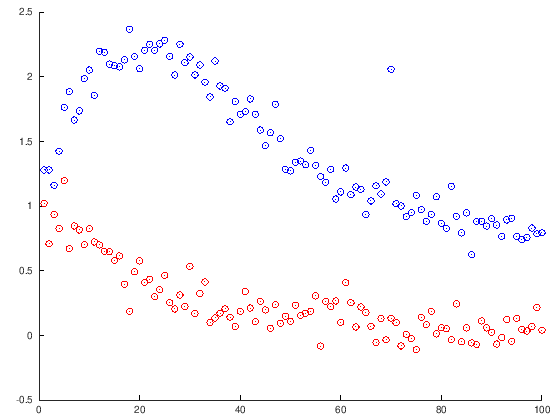

In [10]:
close all
clc
import casadi.*

load('y.mat');
figure
hold on
plot(y(1,:),'ro')
plot(y(2,:),'bo')
hold off

## Set-up a nonlinear fitting problem

In [12]:
Ns    = 100; % Number of simulation steps (= number of observations)
sigma = 0.1; % Huber tuning term

% Unknown parameters of dynamic system
alpha = MX.sym('alpha');
beta  = MX.sym('beta');
gamma = MX.sym('gamma');
delta = MX.sym('delta');
p     = [alpha;beta;gamma;delta]; % p in R^4

% Discrete-time nonlinear dynamic system (predator-prey)
x      = MX.sym('x',2); % symbolic state, in R^2
x_next = [(x(1)-alpha*x(1)*x(2))/(1+gamma*x(1));
          (x(2)+ beta*x(1)*x(2))/(1+delta*x(2))];

% System dynamics: R^2 (state) x R^4 (parameter) -> R^2 (state at next)
S = Function('S',{x,p},{x_next},{'x','p'},{'x_next'})

S =

S:(x[2],p[4])->(x_next[2]) MXFunction



ans =

     2   100

ans =

     2   100

G =

G:(i0[206])->(o0[200]) MXFunction



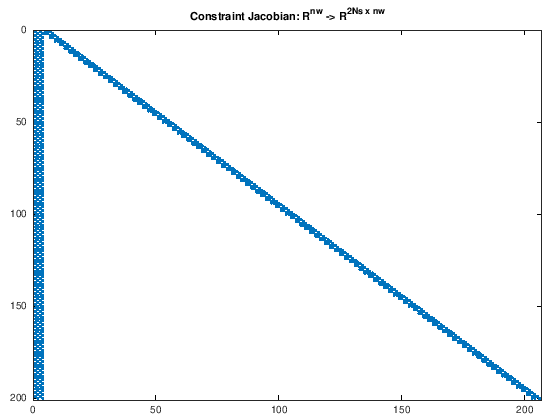

In [13]:
X = MX.sym('X',2,Ns+1); % Symbolic state trajectory, in R^(2 x Ns+1)

% Decision variable structure w in R^nw : nw = 4+2(Ns+1)
w = [p;X(:)];

size(y) % Noisy state observations R^(2 x Ns)
% Error between state and observation: R^nw -> R^(2Ns)
err = X(:,2:Ns+1)-y;
E = Function('E',{w},{ err(:) });

% Express multiple shooting gaps
k = 1:Ns;
mshooting_gaps = X(:,k+1)-S(X(:,k),p);
size(mshooting_gaps) % Gaps are in R^(2 x Ns)

% Constraint: R^nw -> R^(2Ns)
G = Function('G',{w},{ mshooting_gaps(:) })

figure
spy(jacobian(G(w),w))
title('Constraint Jacobian: R^{nw} -> R^{2Ns x nw}')
JG = Function('JG',{w},{ jacobian(G(w),w) });

Q1: Explain the above-displayed structure of $\frac{\partial G(w)}{\partial w}$

## Initial w

In [14]:
% We have a vague idea of the values of p
pinit = [0.03;0.25;0.35;0.05];

% We can initialize with the measurements y!
winit = [pinit;y(:,1);y(:)];

## SCP approach

In [15]:
% Jacobian of error Function: R^nw -> R^(2Ns x nw)
JE = Function('JE',{w},{ jacobian(E(w),w) });

wk = winit;
for k=1:10
    opti = Opti('conic');

    % Decision variables of conic problem
    dw = opti.variable(numel(w));
    s  = opti.variable(2*Ns,1);   % Slack
    
    % Objective: sum of slacks
    opti.minimize(sum(s));
    
    % Second-order cone constraints,
    %  arising from objective   sum_i sqrt(sigma^2+E_i(w)^2)
    E_lin = E(wk)+JE(wk)*dw;
    for i=1:2*Ns
        opti.subject_to( norm([sigma;E_lin(i)]) <= s(i) );
    end

    % Linear equality constraints (cfr. gap-closing multiple shooting)
    G_lin = G(wk)+JG(wk)*dw;
    opti.subject_to( G_lin==0 );

    % Choose a conic solver
    options = struct;
    options.superscs.max_iters = 1e5;
    options.superscs.verbose   = 0;
    options.superscs.eps       = 1e-9;
    opti.solver('superscs',options);
    
    % Solve
    sol = opti.solve();
    dw  = sol.value(dw);
    
    % Take a full step
    wk = wk+dw;
    
    fprintf('SCP it %d: ||dw|| %e\n',k, norm(dw));
end

p_opt_SCP = wk(1:4);

SCP it 1: ||dw|| 2.247828e+00
SCP it 2: ||dw|| 1.669549e+00
SCP it 3: ||dw|| 7.380279e-01
SCP it 4: ||dw|| 4.684862e-01
SCP it 5: ||dw|| 5.741071e-02
SCP it 6: ||dw|| 1.530956e-03
SCP it 7: ||dw|| 8.165646e-05
SCP it 8: ||dw|| 6.274272e-06
SCP it 9: ||dw|| 5.099303e-07
SCP it 10: ||dw|| 4.364257e-08


## GGN approach

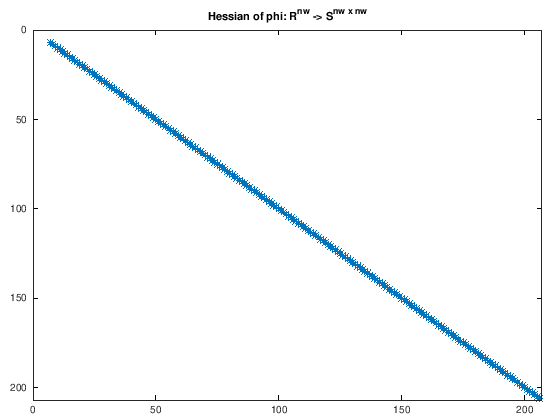

In [16]:
% Convex map: R^nw -> R
phi  = Function('phi',{w},{ sum(sqrt(sigma^2+E(w).^2))/(2*Ns) });

% Jacobian of phi: R^nw -> R^(1 x nw)
Jphi = Function('Jphi',{w},{ jacobian(phi(w),w) });

figure
spy(hessian(phi(w),w))
title('Hessian of phi: R^{nw} -> S^{nw x nw}')
Hphi = Function('Hphi',{w},{ hessian(phi(w),w) });

Q2: Explain the above-displayed structure of $\frac{\partial^2 \phi(w)}{\partial w^2}$.

Q3: Fill in the objective function to create a GGN method.

In [17]:
wk = winit;
for k=1:10
    opti = Opti('conic');

    % Decision variables of quadratic problem
    dw = opti.variable(numel(w));

    error('Fill in the gap here');
    %opti.minimize(...);

    % Linear equality constraints (cfr. multiple shooting)
    G_lin = G(wk)+JG(wk)*dw;
    opti.subject_to( G_lin==0 );

    % Choose a QP solver
    options = struct;
    options.print_iter   = false;
    options.print_header = false;
    opti.solver('qrqp',options);
    
    % Solve
    sol = opti.solve();
    dw  = sol.value(dw);
    
    % Take a full step
    wk = wk+dw;
    
    fprintf('GGN it %d: ||dw|| %e\n',k, norm(dw));
end

p_opt_GGN = wk(1:4);

error: Fill in the gap here


## Comparison

In [18]:
disp('Difference between p_opt_GGN and p_opt_SCP')
p_opt_GGN-p_opt_SCP

Difference between p_opt_GGN and p_opt_SCP
ans =

   0.0093066
   0.1466655
   0.3492020
   0.0281250



## Plotting

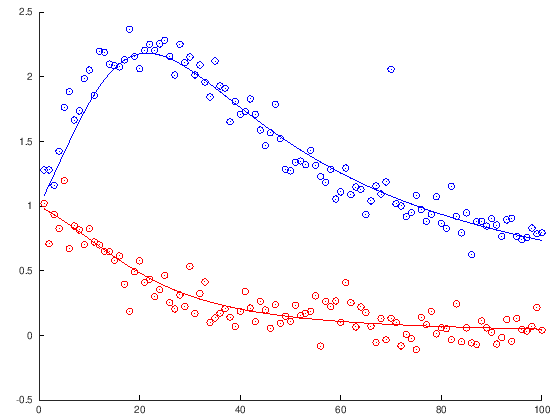

In [8]:
figure
hold on
Sim = S.mapaccum(100);
plot(y(1,:),'ro')
plot(y(2,:),'bo')
sim = full(Sim([1;1],p_opt_GGN)); 
plot(sim(1,:),'r','linewidth',3);
plot(sim(2,:),'b','linewidth',3);